Look at the <a href="http://berkeleyearth.org/data/">Berkeley Earth</a> data to find global temperature values:
* `site_detail.txt` to identify the stations by latitude, longitude and elevation
* `data.txt` contains the data
>Date: The date of a measurement is expressed as a year and decimal fraction of a year corresponding to the midpoint of the time period being represented.  
>
>For example, in monthly data: 
>    January 2005 = 2005 + (1 - 0.5) / 12 = 2005.042
> 	June 2008 = 2008 + (6 - 0.5) / 12 = 2008.458
> 
>For example, in daily data: 
>	January 25, 2005 (Day 25) = 2005 + (25 - 0.5)/365 =2005.067
>	June 3, 2008 (Day 155) = 2008 + (155 - 0.5)/366 = 2008.422
>			[Note the use of 366, during leap years.]

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Retrieving the coffee production schedule

In [5]:
coffee_harvest_schedule = pd.read_csv("../datasets/capstone/coffee harvest schedule.csv", index_col = 0)
coffee_harvest_schedule.head(8)


,Producing Country,Harvest Begins,Harvest Ends,Year-round Harvest,Arabica,Robusta
0,Angola,4,6,False,True,False
1,Angola,5,9,False,False,True
2,Benin,11,2,False,False,True
3,Bolivia,4,8,False,True,False
4,Borneo,6,12,False,True,False
5,Borneo,5,12,False,False,True
6,Brazil,4,9,False,True,False
7,Brazil,4,9,False,False,True


### Defining functions

In [6]:
# Determining seasons by month
def get_season (month, hemisphere = None):
    northern_hemisphere_seasons = {1: 'Winter', 2: 'Winter', 3: 'Winter', 4: 'Spring', 5: 'Spring', 6: 'Spring', 7: 'Summer', 8: 'Summer', 9: 'Summer', 10: 'Fall', 11: 'Fall', 12: 'Fall'}
    southern_hemisphere_seasons = {7: 'Winter', 8: 'Winter', 9: 'Winter', 10: 'Spring', 11: 'Spring', 12: 'Spring', 1: 'Summer', 2: 'Summer', 3: 'Summer', 4: 'Fall', 5: 'Fall', 6: 'Fall'}

    if hemisphere.lower() == "northern":
        season = northern_hemisphere_seasons[month]
    elif hemisphere.lower() == "southern":
        season = southern_hemisphere_seasons[month]
    
    return season

In [7]:
# Converting date fraction to datetime
def convert_date_fraction_series_to_datetime(series = None):
    
    # Separate month decimal and year
    month_decimal = np.mod(series, 1)
    year = (series - month_decimal).astype(int)
    
    # Convert month decimal to month integer (1 = January, 2 = February, etc.)
    month = np.round(12 * month_decimal + 0.5).astype(int)
    
    # Concatenate the values together into a string
    date = year.astype(str) + "-" + month.astype(str) + "-01"
    
    # Convert the date strings into datetime values
    series = pd.to_datetime(date, yearfirst = True)
    
    return series

In [75]:
def observation_in_harvest_season(temperature_data_row):
    country = temperature_data_row["Country"]
    crop = ("Robusta", "Arabica")[temperature_data_row["Arabica Production"]]
    month = temperature_data_row.name.month
#     crop = ("Robusta", "Arabica")[arabica_crop]
    harvest_schedule = coffee_harvest_schedule[(coffee_harvest_schedule["Producing Country"] == country) 
                                  & (coffee_harvest_schedule[crop])][["Harvest Begins", "Harvest Ends"]]
    harvest_month_range = harvest_schedule.values.tolist()[0]
    return(harvest_month_range[0] <= month <= harvest_month_range[1])

# observation_in_harvest_season(temperature_data[(temperature_data["Country"] == "Angola") & (temperature_data.index.month == 4)].iloc[0])
# for row in temperature_data[(temperature_data["Country"] == "Angola")].iterrows():
#     print(observation_in_harvest_season(row[1]))
    

False
False
False
False
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False
False
False
False
False
True
True
True
True
True
False
False
False


### Selecting weather stations by growing conditions

In [9]:
raw_station_data = pd.read_csv("../datasets/capstone/downloaded data/berkeley_earth_stations--site_detail.txt", 
                               delimiter = "\t", 
                               skiprows =148, 
                               names = ["Station ID", 
                                        "Station Name", 
                                        "Latitude", 
                                        "Longitude", 
                                        "Elevation (m)", 
                                        "Lat. Uncertainty", 
                                        "Long. Uncertainty", 
                                        "Elev. Uncertainty (m)", 
                                        "Country", 
                                        "State / Province Code", 
                                        "County", 
                                        "Time Zone", 
                                        "WMO ID", 
                                        "Coop ID", 
                                        "WBAN ID", 
                                        "ICAO ID", 
                                        "# of Relocations", 
                                        "# Suggested Relocations", 
                                        "# of Sources", 
                                        "Hash"])

### Cleaning station data

In [10]:
station_data = raw_station_data.copy()

# Select only relevant columns
station_data = station_data[["Station ID", "Station Name", "Latitude", "Longitude", "Elevation (m)", "Lat. Uncertainty", "Long. Uncertainty", "Elev. Uncertainty (m)", "Country"]]

# Convert values in numerical columns
numeric_columns_in_stations_data = ["Latitude", "Longitude", "Elevation (m)", "Lat. Uncertainty", "Long. Uncertainty", "Elev. Uncertainty (m)"]
station_data.loc[:, numeric_columns_in_stations_data] = station_data[numeric_columns_in_stations_data].apply(pd.to_numeric, errors = 'coerce')

# Remove whitespace from non-numerical columns
station_data.loc[:, "Station Name"] = station_data["Station Name"].str.strip()
station_data.loc[:, "Country"] = station_data["Country"].str.strip()

stations_in_coffee_producing_countries = station_data[station_data["Country"].isin(coffee_harvest_schedule["Producing Country"])]

hemisphere_dictionary = (station_data.groupby(by = "Country")["Latitude"].mean() > 0).map({True: "Northern", False: "Southern"}).to_dict()


In [11]:
# Arabica grows best in elevations 548 m – 1100 m for latitudes between 16° and 24°, or 1097 m – 1920 m for latitudes less that ±10°
arabica_growing_conditions_criteria = (stations_in_coffee_producing_countries["Elevation (m)"] >= 548) & (stations_in_coffee_producing_countries["Elevation (m)"] <= 1100) & (stations_in_coffee_producing_countries["Latitude"].abs() > 16) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 24)
arabica_growing_conditions_criteria = arabica_growing_conditions_criteria | ((stations_in_coffee_producing_countries["Elevation (m)"] >= 1097) & (stations_in_coffee_producing_countries["Elevation (m)"] <= 1920) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 10))

# Robusta grows best in elevations 0 m – 914 m in latitudes between ±10°
robusta_growing_conditions_criteria = (stations_in_coffee_producing_countries["Elevation (m)"] <= 914) & (stations_in_coffee_producing_countries["Latitude"].abs() <= 10)

# Select the stations in the ideal coffee growing regions
stations_in_arabica_conditions = stations_in_coffee_producing_countries[arabica_growing_conditions_criteria]["Station ID"]
stations_in_robusta_conditions = stations_in_coffee_producing_countries[robusta_growing_conditions_criteria]["Station ID"]

stations_in_arabica_conditions_dictionary = dict.fromkeys(stations_in_arabica_conditions.values, True)
stations_in_robusta_conditions_dictionary = dict.fromkeys(stations_in_robusta_conditions.values, True)


### Importing weather data

In [12]:
# Import raw temperature data from Berkeley Earth
raw_temperature_data = pd.read_csv("../datasets/capstone/downloaded data/berkeley_earth -- data.txt", 
            delimiter = "\t",  
            skiprows = 111, 
            names = ["Station ID", 
                     "Series Number", 
                     "Date", 
                     "Temperature (C)", 
                     "Uncertainty (C)", 
                     "Observations", 
                     "Time of Observation"])

### Cleaning weather data

In [13]:
temperatures_for_all_stations = raw_temperature_data.copy()

# Remove unnecessary labels
temperatures_for_all_stations.drop(labels = ["Series Number", "Uncertainty (C)", "Observations", "Time of Observation"], axis = 1, inplace = True)

# Select the temperature data for stations in coffee growing regions, and add country names
temperatures_for_coffee_producing_countries = temperatures_for_all_stations[temperatures_for_all_stations["Station ID"].isin(stations_in_coffee_producing_countries["Station ID"])]
temperatures_for_coffee_producing_countries = stations_in_coffee_producing_countries[["Station ID", "Country"]].merge(temperatures_for_coffee_producing_countries, on = "Station ID")

# Add columns indicating each station's hemisphere (for seasonality calculations later)
temperatures_for_coffee_producing_countries["Hemisphere"] = temperatures_for_coffee_producing_countries["Country"].map(hemisphere_dictionary)

# Designate stations in areas that grow arabica and robusta coffee
temperatures_for_coffee_producing_countries["Arabica Production"] = temperatures_for_coffee_producing_countries["Station ID"].map(stations_in_arabica_conditions_dictionary)
temperatures_for_coffee_producing_countries["Robusta Production"] = temperatures_for_coffee_producing_countries["Station ID"].map(stations_in_robusta_conditions_dictionary)
temperatures_for_coffee_producing_countries = temperatures_for_coffee_producing_countries.fillna(False)

# Keep the stations in areas that grow arabica or robusta coffee
temperature_data = temperatures_for_coffee_producing_countries[
    temperatures_for_coffee_producing_countries["Arabica Production"]
    | temperatures_for_coffee_producing_countries["Robusta Production"]]

# Drop the Station ID column since it's no longer needed
temperature_data.drop("Station ID", axis = 1, inplace = True)

# Convert dates to datetime values
temperature_data.loc[:, "Date"] = convert_date_fraction_series_to_datetime(temperature_data["Date"])

# Index by date
temperature_data.index = temperature_data["Date"].values
temperature_data = temperature_data.sort_index()
temperature_data = temperature_data.drop("Date", axis = 1)

# Add seasons columns
temperature_data["Season"] = temperature_data.index.month
temperature_data.loc[temperature_data["Hemisphere"] == "Northern", "Season"] = temperature_data[temperature_data["Hemisphere"] == "Northern"]["Season"].apply(lambda x: get_season(x, hemisphere = "Northern"))
temperature_data.loc[temperature_data["Hemisphere"] == "Southern", "Season"] = temperature_data[temperature_data["Hemisphere"] == "Southern"]["Season"].apply(lambda x: get_season(x, hemisphere = "Southern"))


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Feature engineering

In [14]:
# Add frost likelihood
temperature_data["Frost likelihood"] = temperature_data["Temperature (C)"] ** -2

### Visualizing stations in growing regions

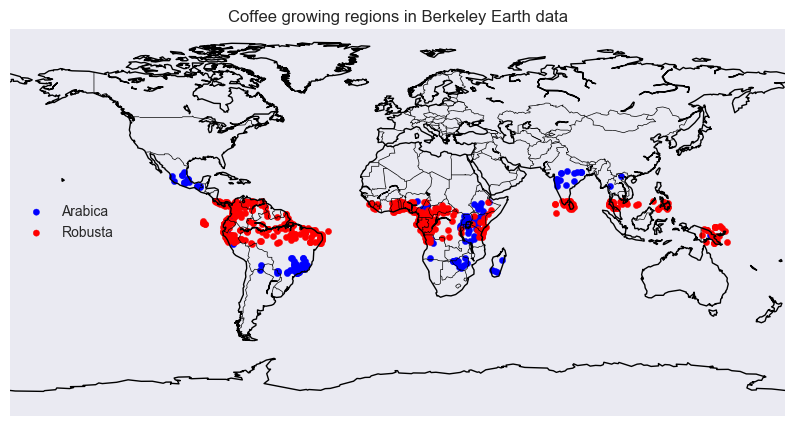

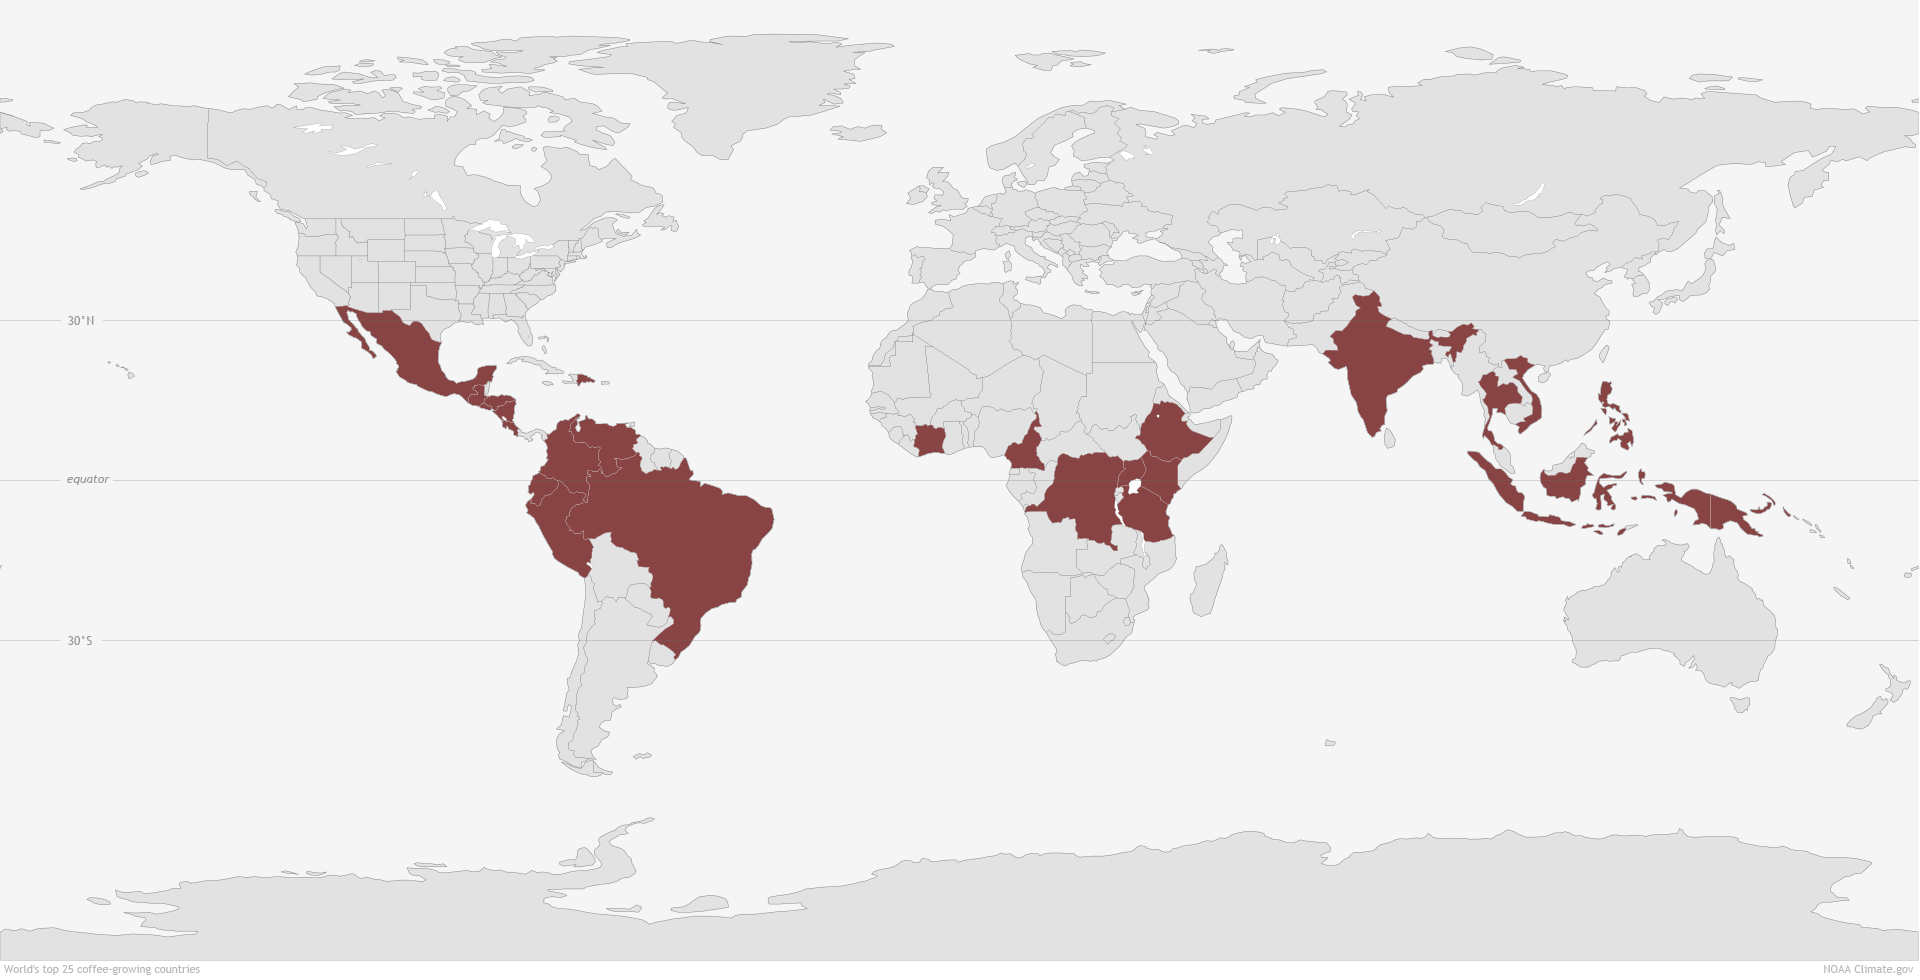

In [15]:
from mpl_toolkits.basemap import Basemap

arabica_producing_locations = pd.DataFrame(stations_in_arabica_conditions).merge(stations_in_coffee_producing_countries[["Station ID", "Latitude", "Longitude"]], on = "Station ID")
robusta_producing_locations = pd.DataFrame(stations_in_robusta_conditions).merge(stations_in_coffee_producing_countries[["Station ID", "Latitude", "Longitude"]], on = "Station ID")

arabica_longitudes = arabica_producing_locations["Longitude"].tolist()
arabica_latitudes = arabica_producing_locations["Latitude"].tolist()

robusta_longitudes = robusta_producing_locations["Longitude"].tolist()
robusta_latitudes = robusta_producing_locations["Latitude"].tolist()


fig = plt.figure(figsize = (10,16))
station_map = Basemap()

arabica_x, arabica_y = station_map(arabica_longitudes, arabica_latitudes)
station_map.scatter(arabica_x, arabica_y, color='b')

robusta_x, robusta_y = station_map(robusta_longitudes, robusta_latitudes)
station_map.scatter(robusta_x, robusta_y, color='r')


station_map.drawcoastlines()
station_map.drawcountries()

plt.title("Coffee growing regions in Berkeley Earth data")
plt.legend(["Arabica", "Robusta"], loc = 'center left')
plt.show()

from IPython.display import Image
Image("https://www.climate.gov/sites/default/files/CoffeeGrowingCountries_large.jpg")

### Exporting final temperatures dataframe

In [16]:
temperature_data_since_1990 = temperature_data[temperature_data.index.year > 1989]

# temperature_data.to_csv("../datasets/capstone/temperature-in-coffee-growing-regions--from-berkeley-earth.csv")